In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [4]:
data = pd.read_csv("Bioderma_labeled.csv")

In [6]:
data.drop(['Positive','Negative','Neutral','Compound'],axis=1,inplace=True)


,Review,Sentiment
0,Nice sunscreen but pricey and makes face littl...,Positive
1,its good for dry skin,Positive
2,I like the high UVA protection that the suncre...,Negative
3,This sunscreen is extremly good at sun protect...,Positive
4,It has no scent so that's the best part actual...,Positive
...,...,...
2815,"expensive. However, it blends easily and I use...",Positive
2816,long! I use it everyday before I go out. The p...,Neutral
2817,it still has the nozzle.,Neutral
2818,It doesn't leave a white cast on my NC/NW20-25...,Neutral


In [7]:
data.drop(data[(data['Sentiment'] =='Neutral')].index, inplace=True)
data

,Review,Sentiment
0,Nice sunscreen but pricey and makes face littl...,Positive
1,its good for dry skin,Positive
2,I like the high UVA protection that the suncre...,Negative
3,This sunscreen is extremly good at sun protect...,Positive
4,It has no scent so that's the best part actual...,Positive
...,...,...
2811,the water my face is still oily. But good side...,Positive
2812,sensitive skin is calm and it really protects ...,Positive
2813,I was recommended this by a friend as I have e...,Positive
2814,"sunscreen is very liquid, when I applied it on...",Positive


In [22]:
df=data
df

,Review,Sentiment
0,Nice sunscreen but pricey and makes face littl...,Positive
1,its good for dry skin,Positive
2,I like the high UVA protection that the suncre...,Negative
3,This sunscreen is extremly good at sun protect...,Positive
4,It has no scent so that's the best part actual...,Positive
...,...,...
2811,the water my face is still oily. But good side...,Positive
2812,sensitive skin is calm and it really protects ...,Positive
2813,I was recommended this by a friend as I have e...,Positive
2814,"sunscreen is very liquid, when I applied it on...",Positive


In [23]:
df['Sentiment'] = df['Sentiment'].replace(['Positive'], 1)

In [25]:
df['Sentiment'] = df['Sentiment'].replace(['Negative'], 0)

In [26]:
df

,Review,Sentiment
0,Nice sunscreen but pricey and makes face littl...,1
1,its good for dry skin,1
2,I like the high UVA protection that the suncre...,0
3,This sunscreen is extremly good at sun protect...,1
4,It has no scent so that's the best part actual...,1
...,...,...
2811,the water my face is still oily. But good side...,1
2812,sensitive skin is calm and it really protects ...,1
2813,I was recommended this by a friend as I have e...,1
2814,"sunscreen is very liquid, when I applied it on...",1


In [27]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
X_train = train['Review'].values
X_test = test['Review'].values
y_train = train['Sentiment']
y_test = test['Sentiment']

In [28]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [29]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [30]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
print(grid_svm.score(X_test, y_test)*100)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
83.38738972496108


In [31]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [32]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.8339387649195642,
 'f1': 0.8362573099415205,
 'acc': 0.7554585152838428,
 'precision': 0.9285714285714286,
 'recall': 0.7606382978723404}

In [33]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [34]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

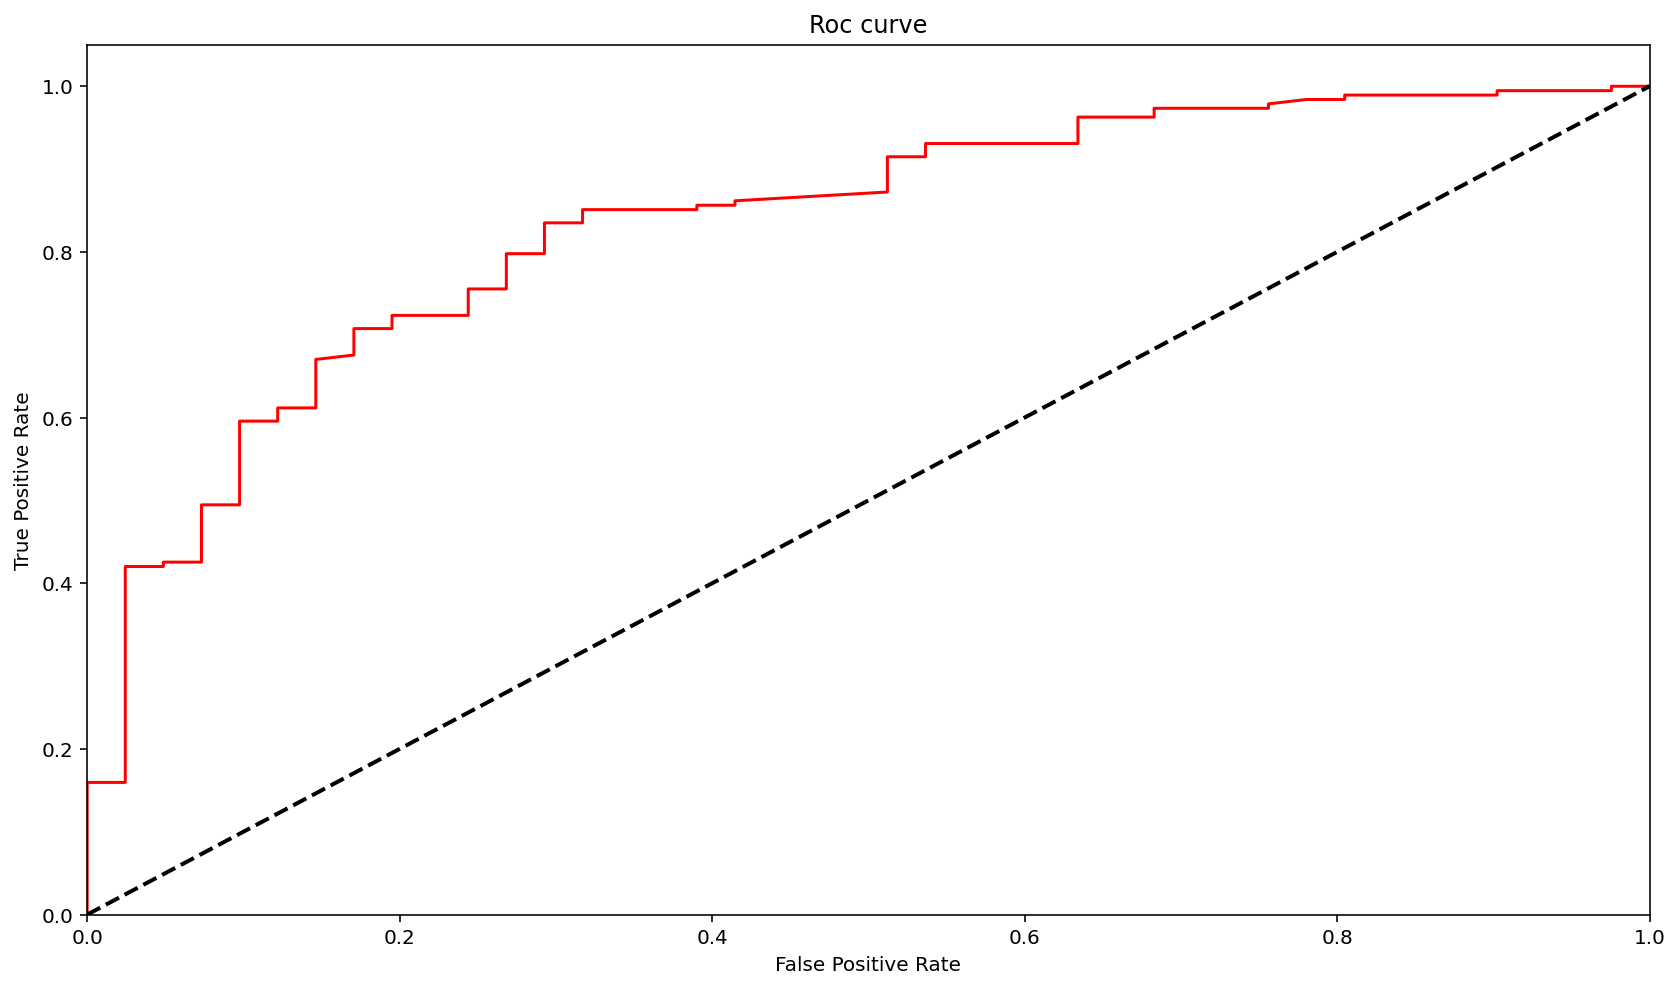

In [35]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [45]:
conda install -c conda-forge wordcloud=1.6.0 


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.





==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 22.11.1

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - wordcloud=1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.12.0               |   py38haa244fe_0         1.0 MB  conda-forge
    wordcloud-1.6.0            |   py38hfa6e2cd_0         189 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.8-2_cp38
  wordcloud          conda-forge/win-64::wordcloud-1.6.0-py38hfa6e2cd_0

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.1-py38haa95532_1 --> conda-forge::conda-4.12.0-py38haa244fe_0




wordcloud-1.6.0      | 189 KB    |            |   0% 
wordcloud-1.6.0      |



Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3





wordcloud-1.6.0      | 189 KB    | ######7    |  68% 
wordcloud-1.6.0      | 189 KB    | ########## | 100% 
wordcloud-1.6.0      | 189 KB    | ########## | 100% 

conda-4.12.0         | 1.0 MB    |            |   0% 
conda-4.12.0         | 1.0 MB    | 1          |   2% 
conda-4.12.0         | 1.0 MB    | #          |  11% 
conda-4.12.0         | 1.0 MB    | ##1        |  22% 
conda-4.12.0         | 1.0 MB    | ###1       |  31% 
conda-4.12.0         | 1.0 MB    | ####3      |  43% 
conda-4.12.0         | 1.0 MB    | #####5     |  56% 
conda-4.12.0         | 1.0 MB    | ########2  |  82% 
conda-4.12.0         | 1.0 MB    | ########## | 100% 
conda-4.12.0         | 1.0 MB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... failed


In [48]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


(-0.5, 399.5, 199.5, -0.5)

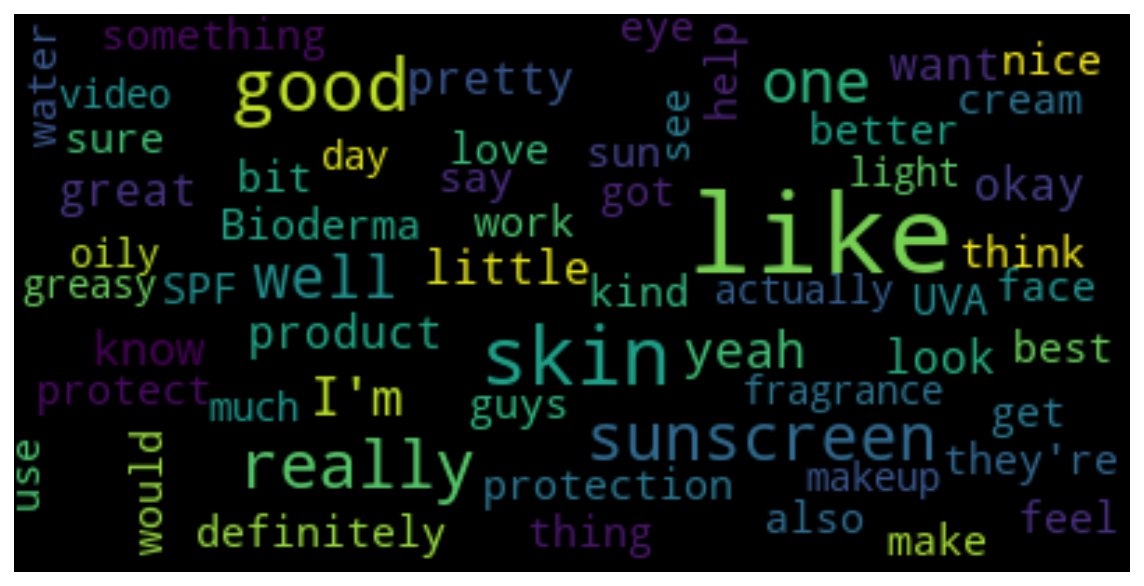

In [67]:
#Remove un-important words from text
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
query_words={'recession', '#' }
stop_words.update(query_words)
for word in query_words:
    data.translated_text = data.Review.str.replace(word, '')
#Creating word cloud
from wordcloud import WordCloud, ImageColorGenerator
wc=WordCloud(stopwords=stop_words, collocations=False, max_font_size=40, max_words=60, background_color="black")
wc.generate(' '.join(data.translated_text))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
